In [ ]:
!nvidia-smi

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import pickle as pk
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0E:00.0)


In [ ]:
# Reloading
importlib.reload(ext)
importlib.reload(utils)
importlib.reload(metrics)
importlib.reload(visuals)
print("All Done")

In [2]:
%time
modelpath   = "data/models/UNIF-10N-25T-1000E-235R.h5"
trainpath   = "data/sets/UNIF-10N-25T-1000E-235R.gz"
testpath    = "data/sets/RAMP-10N-25T-235R.gz"
train_frame = pd.read_csv(trainpath)
test_frame  = pd.read_csv(testpath)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs


In [4]:
%%time
train = utils.list_of_groups(train_frame, group="event_id")
test  = utils.list_of_groups(test_frame,  group="event_id")
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))

Train is list of 25000 events.
Test is list of 3600 events.
CPU times: user 4.63 s, sys: 6.39 s, total: 11 s
Wall time: 11 s


In [22]:
order = ["r", "phi", "z"]

Train 8881
Number of Hits: 87
Number of Tracks: 9


<IPython.core.display.Javascript object>


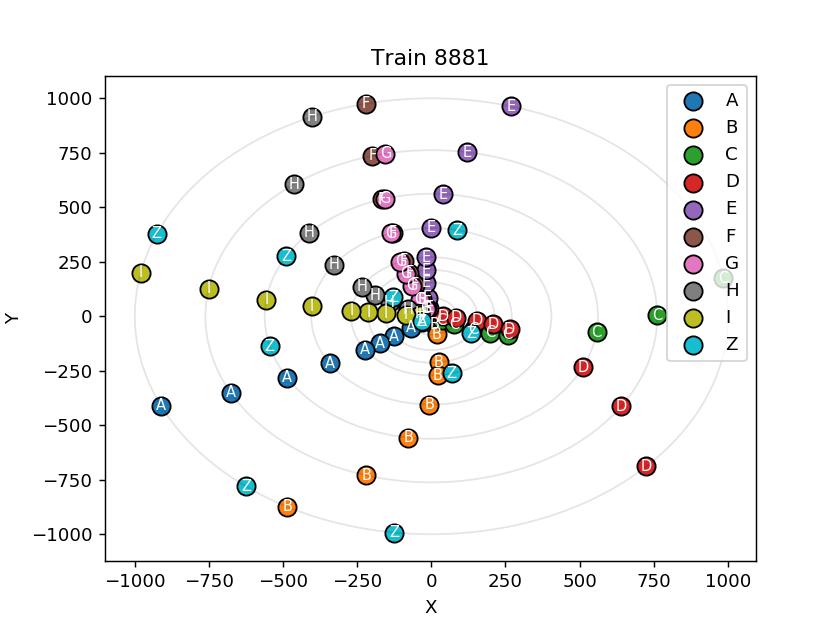

In [23]:
n = 8881 #np.random.randint(len(train))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(train[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(train[n])))
visuals.Plot2D(train[n], order).plot(mode="xy", title="Train {}".format(n))

In [24]:
print(n)
visuals.display(train[n], order)

8881


,r,phi,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,noise,pad
0,39.0,-2.546779,117.754959,,,,,,,,,,,,,,,,,,,,,,,,,,1,
1,39.0,-2.462780,-1.883299,1,,,,,,,,,,,,,,,,,,,,,,,,,,
2,39.0,-1.305687,4.469421,,1,,,,,,,,,,,,,,,,,,,,,,,,,
3,39.0,-0.489588,1.612450,,,1,,,,,,,,,,,,,,,,,,,,,,,,
4,39.0,-0.025436,2.252373,,,,1,,,,,,,,,,,,,,,,,,,,,,,
5,39.0,1.734821,5.959208,,,,,1,,,,,,,,,,,,,,,,,,,,,,
6,39.0,1.944986,6.333823,,,,,,1,,,,,,,,,,,,,,,,,,,,,
7,39.0,2.055167,2.955487,,,,,,,1,,,,,,,,,,,,,,,,,,,,
8,39.0,2.783743,-1.437834,,,,,,,,1,,,,,,,,,,,,,,,,,,,
9,39.0,3.039183,-5.098158,,,,,,,,,1,,,,,,,,,,,,,,,,,,


In [25]:
input_shape  = (235, 3)
n_categories = 25 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

In [26]:
model = Sequential()
model.add(Bidirectional(
    GRU(
        units=256, 
        return_sequences=True,
        recurrent_dropout=2/5,
        implementation=2),
    merge_mode="mul",
    input_shape=input_shape))
model.add(Dropout(rate=2/5))
model.add(Bidirectional(
    GRU(
        units=256, 
        return_sequences=True,
        recurrent_dropout=2/5,
        implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=2/5))
model.add(Bidirectional(
    GRU(
        units=256, 
        return_sequences=True,
        recurrent_dropout=2/5,
        implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=2/5))
model.add(TimeDistributed(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax")))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 235, 256)          399360    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 235, 256)          787968    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 235, 256)          787968    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 235, 27)           6939      
Total params: 1,982,235
Trainable params: 1,982,235
Non-trainable params: 0
_________________________________________________________________


In [27]:
%%time
train_input  = ext.extract_input (train, order)
train_target = ext.extract_output(train, order)
test_input   = ext.extract_input (test,  order)
test_output  = ext.extract_output(test,  order)
print(train_input.shape)
print(train_target.shape)
print(test_input.shape)
print(test_output.shape)

(25000, 235, 3)
(25000, 235, 27)
(3600, 235, 3)
(3600, 235, 27)
CPU times: user 2min 2s, sys: 648 ms, total: 2min 2s
Wall time: 2min 3s


In [29]:
print(train_input[n])

[[  3.90000000e+01  -2.54677934e+00   1.17754959e+02]
 [  3.90000000e+01  -2.46277969e+00  -1.88329900e+00]
 [  3.90000000e+01  -1.30568702e+00   4.46942137e+00]
 [  3.90000000e+01  -4.89588101e-01   1.61245040e+00]
 [  3.90000000e+01  -2.54356969e-02   2.25237341e+00]
 [  3.90000000e+01   1.73482061e+00   5.95920751e+00]
 [  3.90000000e+01   1.94498647e+00   6.33382293e+00]
 [  3.90000000e+01   2.05516658e+00   2.95548675e+00]
 [  3.90000000e+01   2.78374319e+00  -1.43783433e+00]
 [  3.90000000e+01   3.03918308e+00  -5.09815782e+00]
 [  8.50000000e+01  -2.48555520e+00  -4.10462603e+00]
 [  8.50000000e+01  -1.35411837e+00   9.74104658e+00]
 [  8.50000000e+01  -4.48208280e-01   3.51431498e+00]
 [  8.50000000e+01  -8.16685812e-02   4.90901898e+00]
 [  8.50000000e+01   1.71582253e+00   1.29880164e+01]
 [  8.50000000e+01   1.94363609e+00   1.38044859e+01]
 [  8.50000000e+01   2.03346803e+00   6.44144548e+00]
 [  8.50000000e+01   2.76334875e+00  -3.13374148e+00]
 [  8.50000000e+01   3.05969

In [30]:
%%time
# 8 + 16
epochs     = 8
batch_size = 64
histories.append(model.fit(
    train_input,
    train_target,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_input, test_output),
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,),
        keras.callbacks.ReduceLROnPlateau(patience=3)]))

Train on 25000 samples, validate on 3600 samples
Epoch 1/8
25000/25000 [==============================] - 352s - loss: 1.3811 - acc: 0.5869 - val_loss: 0.6828 - val_acc: 0.7583
Epoch 2/8
25000/25000 [==============================] - 347s - loss: 0.9150 - acc: 0.6770 - val_loss: 0.5465 - val_acc: 0.8088
Epoch 3/8
25000/25000 [==============================] - 349s - loss: 0.8404 - acc: 0.6983 - val_loss: 0.5154 - val_acc: 0.8144
Epoch 4/8
25000/25000 [==============================] - 348s - loss: 0.8042 - acc: 0.7089 - val_loss: 0.5014 - val_acc: 0.8173
Epoch 5/8
25000/25000 [==============================] - 347s - loss: 0.7814 - acc: 0.7161 - val_loss: 0.4801 - val_acc: 0.8215
Epoch 6/8
25000/25000 [==============================] - 347s - loss: 0.7650 - acc: 0.7211 - val_loss: 0.4804 - val_acc: 0.8216
Epoch 7/8
25000/25000 [==============================] - 348s - loss: 0.7535 - acc: 0.7245 - val_loss: 0.4610 - val_acc: 0.8269
Epoch 8/8
25000/25000 [==============================] 